In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler #la fct qu'on utilise pr normaliser notre bd
#importer le modèle séquentiel
from tensorflow.keras.models import Sequential
#importer les pachages responsables sur les couches
from tensorflow.keras.layers import Dense,LSTM #LSMT c'est pour créer les couches RNN

In [ ]:
apikey = ''
secret = ''

In [ ]:
!pip install python-binance

In [ ]:
from binance import Client

In [ ]:
client = Client(apikey, secret)

In [ ]:
historical = client.get_historical_klines('BTCUSDT', Client.KLINE_INTERVAL_1MINUTE, '1 Jan 2022')

In [ ]:
hist_df = pd.DataFrame(historical)
hist_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1640995200000,46216.93000000,46271.08000000,46208.37000000,46250.00000000,40.57574000,1640995259999,1875978.44269790,796,27.26086000,1260270.37206270,0
1,1640995260000,46250.00000000,46344.23000000,46234.39000000,46312.76000000,42.38106000,1640995319999,1961908.27328950,973,28.92522000,1339049.49591330,0
2,1640995320000,46312.76000000,46381.69000000,46292.75000000,46368.73000000,51.29955000,1640995379999,2377413.92816950,1238,22.74786000,1054134.62555590,0
3,1640995380000,46368.73000000,46391.49000000,46314.26000000,46331.08000000,30.45894000,1640995439999,1412003.86548650,953,16.12179000,747308.64985660,0
4,1640995440000,46331.07000000,46336.10000000,46300.00000000,46321.34000000,20.96029000,1640995499999,971009.86278970,591,11.49082000,532319.85702710,0


In [ ]:
data=hist_df[[4,6]]
data.columns=['Close','Close Time']
data

,Close,Close Time
0,46250.00000000,1640995259999
1,46312.76000000,1640995319999
2,46368.73000000,1640995379999
3,46331.08000000,1640995439999
4,46321.34000000,1640995499999
...,...,...
157722,42098.96000000,1650458579999
157723,42067.18000000,1650458639999
157724,42022.43000000,1650458699999
157725,42039.71000000,1650458759999


In [ ]:
data['Close Time'] = pd.to_datetime(data['Close Time']/1000, unit='s')
data[['Close']] = data[['Close']].apply(pd.to_numeric, axis=1)
data.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Close,Close Time
157722,42098.96,2022-04-20 12:42:59.999000064
157723,42067.18,2022-04-20 12:43:59.999000064
157724,42022.43,2022-04-20 12:44:59.999000064
157725,42039.71,2022-04-20 12:45:59.999000064
157726,42039.70,2022-04-20 12:46:59.999000064


In [ ]:
#convertir le dataframe en format array (le format qu'on aura besoin pour notre réseau de norone)
data=data[['Close']].values
data

array([[46250.  ],
       [46312.76],
       [46368.73],
       ...,
       [42022.43],
       [42039.71],
       [42039.7 ]])

In [ ]:
#préparation de la base de donnée
#1)Normaliser la données(toutes les valeurs soit entre 0 et 1)
sc=MinMaxScaler(feature_range=(0,1))
data_scaled=sc.fit_transform(data)
data_scaled

array([[0.87328544],
       [0.87743971],
       [0.88114453],
       ...,
       [0.59344994],
       [0.59459375],
       [0.59459309]])

In [ ]:
data_scaled[0,0]

0.8732854360860354

In [ ]:
#X_data => input
#y_data => output
X_data=[]
y_data=[]
look_back=1
for i in range(len(data_scaled)-1):
  X_data.append(data_scaled[i:(i+look_back),0])
  y_data.append(data_scaled[i+look_back,0])
X_data,y_data=np.array(X_data),np.array(y_data)
print(X_data)
print(y_data)  

[[0.87328544]
 [0.87743971]
 [0.88114453]
 ...
 [0.59641208]
 [0.59344994]
 [0.59459375]]
[0.87743971 0.88114453 0.87865236 ... 0.59344994 0.59459375 0.59459309]


In [ ]:
print(X_data.shape[0],X_data.shape[1])

157726 1


In [ ]:
print(y_data.shape[0])

157726


In [ ]:
# Reshaping (Avoir des données en 3 dimensions pour pouvoir les passer dans notre réseau de neurone)
X_data=np.reshape(X_data,(X_data.shape[0],X_data.shape[1],1))
X_data

array([[[0.87328544]],

       [[0.87743971]],

       [[0.88114453]],

       ...,

       [[0.59641208]],

       [[0.59344994]],

       [[0.59459375]]])

In [ ]:
X_data.shape

(157726, 1, 1)

In [ ]:
# Split data into Test and Train
train_size=int(len(X_data)*0.7) #70% des données d'entrainement
test_size=len(X_data)-train_size
X_train=X_data[0:train_size,:]
X_test=X_data[train_size:len(X_data),:]
y_train=y_data[0:train_size]
y_test=y_data[train_size:len(y_data)]

In [ ]:
X_train.shape

(110408, 1, 1)

In [ ]:
y_train.shape

(110408,)

In [ ]:
X_test.shape

(47318, 1, 1)

In [ ]:
y_test.shape

(47318,)

In [ ]:
#Construction de RNN
#return_sequences=True si on veut ajouter d'autres couches LSTM
#units=50 i-e 50 noeuds
model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))

#Ajouter la couche de sortie
#optimizer pour l'optimisation des poids
#puisque c'est un contexte de regression (prédiction d'une valeur) on utilise la fct du perte suivant
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()
#model.summary() pour afficher les couches

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 50)             10400     
                                                                 
 lstm_4 (LSTM)               (None, 1, 50)             20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#fiting model
model.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
3451/3451 [==============================] - 26s 6ms/step - loss: 0.0028
Epoch 2/100
3451/3451 [==============================] - 21s 6ms/step - loss: 9.2294e-06
Epoch 3/100
3451/3451 [==============================] - 21s 6ms/step - loss: 9.8935e-06
Epoch 4/100
3451/3451 [==============================] - 21s 6ms/step - loss: 9.9268e-06
Epoch 5/100
3451/3451 [==============================] - 21s 6ms/step - loss: 9.4581e-06
Epoch 6/100
3451/3451 [==============================] - 21s 6ms/step - loss: 9.7016e-06
Epoch 7/100
3451/3451 [==============================] - 21s 6ms/step - loss: 9.7309e-06
Epoch 8/100
3451/3451 [==============================] - 21s 6ms/step - loss: 9.2962e-06
Epoch 9/100
3451/3451 [==============================] - 21s 6ms/step - loss: 9.5677e-06
Epoch 10/100
3451/3451 [==============================] - 21s 6ms/step - loss: 9.2100e-06
Epoch 11/100
3451/3451 [==============================] - 21s 6ms/step - loss: 9.2105e-06
Epoch 12/100
3451/3451 

In [ ]:
# faire des prévisions
y_pred=model.predict(X_test)

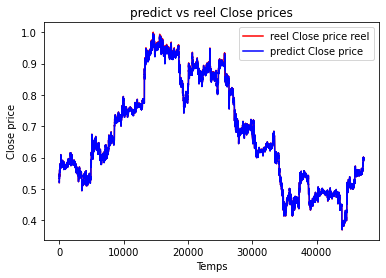

In [ ]:
#visualiser les résultats 
plt.plot(y_test,color='red',label='reel Close price')
plt.plot(y_pred,color='blue',label='predict Close price')
plt.title('predict vs reel Close prices')
plt.xlabel('Temps')
plt.ylabel('Close price')
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
YT=pd.DataFrame(y_test)
YP=pd.DataFrame(y_pred)

In [ ]:
YT.columns=['YT']
YP.columns=['YP']
YP

,YP
0,0.524423
1,0.519974
2,0.526125
3,0.527643
4,0.525371
...,...
47313,0.598931
47314,0.598251
47315,0.596155
47316,0.593204


In [ ]:
YT

,YT
0,0.519914
1,0.526092
2,0.527616
3,0.525334
4,0.524481
...,...
47313,0.598516
47314,0.596412
47315,0.593450
47316,0.594594


Text(0.5, 1.0, 'corrélation entre YT & YP')

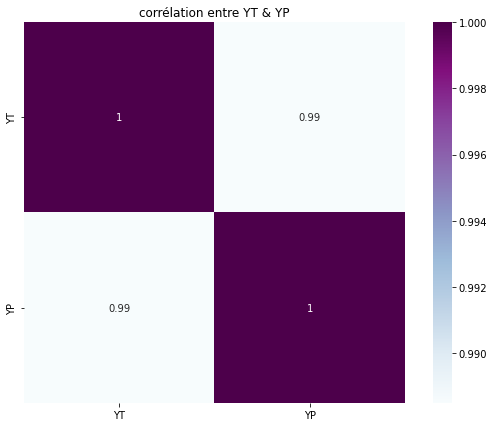

In [ ]:
combined=YT.join(YP)
matrix=combined.head(500).corr()
f,ax=plt.subplots(figsize=(10,7))
sns.heatmap(matrix,vmax=1,square=True,cmap='BuPu',annot=True)
ax.set_title('corrélation entre YT & YP')